In [67]:
from datasets import DatasetDict
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score

In [2]:
import seaborn as sns
sns.set_theme()

In [29]:
# difficulty filter
# delta - candidate fraction
# frac - fraction to remove
#
def diffFilter(df, delta=0.15, phishfrac=0.1, benignfrac=0):
    
    assert delta > phishfrac and delta > benignfrac, "delta must be greater than frac"
    
    # easy phish points
    phish_thresh = df.loc[df.GT == 1].score.quantile(1-delta)
    phish_candidates = df.loc[(df.GT == 1) & (df.score >= phish_thresh)]

    # Randomly sample rows to drop
    n_drop_phish = int(phishfrac * sum(df.GT==1))
    phish_to_drop = phish_candidates.sample(n = n_drop_phish, replace = False)

    
    # easy benign points
    benign_thresh = df.loc[df.GT == 0].score.quantile(delta)
    benign_candidates = df.loc[(df.GT == 0) & (df.score <= benign_thresh)]

    # Randomly sample rows to drop
    n_drop_benign = int(benignfrac * sum(df.GT==0))
    benign_to_drop = benign_candidates.sample(n = n_drop_benign, replace = False)
    
    # Drop the sampled rows from the original dataframe
    df_result = df.drop(np.concatenate([phish_to_drop.index, benign_to_drop.index]))
    
    return df_result

In [4]:
# get one set of benchmarks datasets
def getPhishBench(df, baseRates, id):

    n_benign = np.sum(df.GT == 0)
    n_phish = np.sum(df.GT == 1)
    print(f'num Benign: {n_benign}, num Phish: {n_phish}')
    phishIdx = df.index[df.GT == 1].tolist()
    
    phishSet = {}
    
    np.random.shuffle(phishIdx)
    start = 0
    for b in baseRates:
        num = int(np.ceil(0.01*b*n_benign/(1-0.01*b)))
        print(f'b: {b:.2f}, num: {num}')
        phishSet[f'{b:.2f}-{id}'] = phishIdx[start:(start+num)]

        start = start + num
        
    return phishSet, n_phish - start + 1

In [5]:
def getPhishBench2(df, baseRate):

    n_benign = np.sum(df.GT == 0)
    n_phish = np.sum(df.GT == 1)
    print(f'num Benign: {n_benign}, num Phish: {n_phish}')
    phishIdx = df.index[df.GT == 1].tolist()
    
    phishSet = {}
    num = int(np.ceil(0.01*baseRate*n_benign/(1-0.01*baseRate)))
    num_sets = int(n_phish/num)
    print(f'b: {baseRate:.2f}, num per set: {num}, num sets: {num_sets}')
    
    np.random.shuffle(phishIdx)

    for i in range(num_sets):
        phishSet[f'{baseRate:.2f}-{i}'] = phishIdx[int(i*num):int(i*num+num)]
        
    return phishSet, num_sets  #n_phish - len(phishSet)*num


In [6]:
# get one set of benchmarks datasets
#   with replacement
def getPhishBench3(df, baseRates, id):

    n_benign = np.sum(df.GT == 0)
    n_phish = np.sum(df.GT == 1)
    print(f'num Benign: {n_benign}, num Phish: {n_phish}')
    phishIdx = df.index[df.GT == 1].tolist()
    
    phishSet = {}
    
    for b in baseRates:
        num = int(np.ceil(0.01*b*n_benign/(1-0.01*b)))
        print(f'b: {b:.2f}, num: {num}')
        phishSet[f'{b:.2f}-{id}'] = np.random.choice(phishIdx, size=num, replace=True).tolist()   #phishIdx[start:(start+num)]
       
    return phishSet

In [10]:
def get_data(dir):
    #dir = './Desktop/work/phishing-2/bench/test_1024_both_pred/'
    #dir = './Desktop/work/phishing-2/bench/benchmark_1024_both_pred/'

    ds = DatasetDict.load_from_disk(dir)

    df = pd.concat([
        ds['phishes'].to_pandas(),
        ds['benigns'].to_pandas()
    ]).reset_index(drop=True)

    df = df[['sha256', 'labels', 'score@temp8']]
    df.columns = ['sha256', 'GT', 'score']
    
    return df

In [41]:
def get_benchmark_dict(df, base_rates, nrep=10, method='method2'):
    
    if method == 'method2':
        phish_bench = {}
        num_bench = {}
        for b1 in base_rates:
            pb, num_bench[f'{b1}'] = getPhishBench2(df, b1)
            phish_bench = {**phish_bench, **pb}
            
        return phish_bench, num_bench
    

In [62]:
def get_bench_dataset(df, pb, br, reps):

    data = []
    for rep in range(reps):
        idx = pb[f'{br:.2f}-{rep}']
#        print(idx)
        ytrue = df.loc[idx, 'GT'].tolist() + df[df.GT==0].GT.tolist()
        yscore = df.loc[idx, 'score'].tolist() + df[df.GT==0].score.tolist()
        data.append((ytrue, yscore))
        
    return data

In [52]:
# save phish part of the benchmark datasets to files
def save_to_files(dir, pb, df):
    
    for br_inst, idxs in pb.items():

        fname = f'{dir}/benchmark-{br_inst}.txt'
        #print(fname) 
        files = df.loc[idxs, 'sha256'].tolist()

        #print(files)

        with open(fname, 'w') as f:
            for item in files:
                f.write(f'{item}.json\n')

    benigns = df[df.GT==0].        

In [59]:
# save benign part of the benchmarks to a file
def save_benign(dir, df):
    
    fname = f'{dir}/benign.txt'
    
    bfiles = df[df.GT==0].sha256.tolist()

    with open(fname, 'w') as f:
        for item in bfiles:
            f.write(f'{item}.json\n')

    

In [106]:
def get_ci(data):
    
    n = len(data)
    n_bootstraps = 10000

    # Generate bootstrap resamples and compute means
    bootstrap_means = np.array([
        np.mean(np.random.choice(data, size=n, replace=True))
        for _ in range(n_bootstraps)
    ])

    # Compute 95% confidence interval
    lower = np.percentile(bootstrap_means, 2.5)
    upper = np.percentile(bootstrap_means, 97.5)
    
    return np.mean(data), lower, upper

In [126]:
# plot pr curves list of baserates
def plot_pr_curve(baserates, num_list, pb):
    
    plt.figure(figsize=(8, 8))
    
    for br in baserates:
        
        # datasets = [(ytrue, yscore), (ytrue, yscore)....(ytrue, yscore)]
        
        datasets = get_bench_dataset(df, pb, br, num_list[f'{br}'])

        # Store interpolated precision and recall
        precision_list = []
        recall_list = []
        auc_list = []

        # Define a common recall grid for interpolation (important for averaging)
        recall_grid = np.linspace(0, 1, 1000)

        for y_true, y_pred in datasets:
            precision, recall, _ = precision_recall_curve(y_true, y_pred)
            # Need to sort recall ascending for interpolation
            recall = recall[::-1]
            precision = precision[::-1]
            precision_interp = np.interp(recall_grid, recall, precision)
            recall_list.append(recall_grid)
            precision_list.append(precision_interp)
            plt.plot(recall, precision, color='grey', alpha=1/10)

            auc_list.append(average_precision_score(y_true, y_pred))

        # Average precision over all datasets
        mean_precision = np.mean(precision_list, axis=0)

        # compute precision @ 0.9 recall
        target_recall = 0.9

        # Find the index of the recall value closest to 0.9
        differences = np.abs(recall_grid - target_recall)
        
        # Find the index of the smallest difference
        closest_index = np.argmin(differences)

        # Get the corresponding precision
        precisionAtR = [ x[closest_index] for x in precision_list ]    #mean_precision[closest_index]
        mean_precAtR, low_precAtR, hi_precAtR = get_ci(precisionAtR)
        closest_recall = recall_grid[closest_index]
        
        mean_ap, low_ap, hi_ap = get_ci(auc_list)
        print(f'base rate: {br}, AP: {mean_ap:.4}, 95% CI: ({low_ap:.4}, {hi_ap:.4})')
        print(f'base rate: {br}, Prec@R{closest_recall:.2}: {mean_precAtR:.4}, 95% CI: ({low_precAtR:.4}, {hi_precAtR:.4})')
        
        # Plot the mean Precision-Recall curve
        #    plt.plot(recall_grid, mean_precision, color='black', linewidth=1, label='Average PR Curve')
        plt.plot( recall_grid, mean_precision, linewidth=2, label=f'BR: {br}% (AP: {mean_ap:.4}, P@R({closest_recall:.2}):{mean_precAtR:.3})')


    # Plot settings
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves with Average')
    plt.legend()
    plt.grid(True)
    plt.ylim([0, 1.09])
    plt.xlim([0, 1.09])
    plt.show()
        
        
    
    

In [97]:
# plot pr curves list of baserates
def plot_roc_curve(baserates, num_list, pb):
    
    plt.figure(figsize=(8, 8))

    for br in baserates:
        
        # datasets = [(ytrue, yscore), (ytrue, yscore)....(ytrue, yscore)]
        
        datasets = get_bench_dataset(df, pb, br, num_list[f'{br}'])

        # Store interpolated precision and recall
        tpr_list = []
        fpr_list = []
        auc_list = []

        # Define a common grid for interpolation
        fpr_grid = np.linspace(0, 1, 1000)

        for y_true, y_pred in datasets:
            fpr, tpr, _ = roc_curve(y_true, y_pred)
            # Interpolate TPR at the grid points
            tpr_interp = np.interp(fpr_grid, fpr, tpr)
            fpr_list.append(fpr_grid)
            tpr_list.append(tpr_interp)
            plt.plot(fpr, tpr, color='grey', alpha=1/10)  # individual ROC, transparent        
        
            auc_list.append(roc_auc_score(y_true, y_pred))

        # Compute mean TPR
        mean_tpr = np.mean(tpr_list, axis=0)

        # Plot the mean ROC
        plt.plot(fpr_grid, mean_tpr, linewidth=2, label=f'Base rate: {br}% (AUC: {np.mean(auc_list):.4})')
            
            
    # Plot settings
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves with Average')
    plt.legend()
    plt.grid(True)
    plt.ylim([0.8, 1.01])
    plt.xlim([0.0, 0.2])
    plt.show()


# Main

In [11]:
dname = './Desktop/work/phishing-2/bench/benchmark_1024_both_pred/'
df = get_data(dname)

In [15]:
df.loc[0,'sha256']

'960442e0de653005afb5b596de8ddc29f0d302f30679913335e9b7230dde5a94'

In [30]:
df1 = diffFilter(df)

In [31]:
len(df), len(df1), len(df[df.GT==1]), len(df[df.GT==0]), len(df1[df1.GT==1]), len(df1[df1.GT==0]) 

(34343, 33914, 4295, 30048, 3866, 30048)

In [42]:
b = [0.05, 0.1, 0.5, 1, 5]

pb_dict, nums = get_benchmark_dict(df1, b)

num Benign: 30048, num Phish: 3866
b: 0.05, num per set: 16, num sets: 241
num Benign: 30048, num Phish: 3866
b: 0.10, num per set: 31, num sets: 124
num Benign: 30048, num Phish: 3866
b: 0.50, num per set: 151, num sets: 25
num Benign: 30048, num Phish: 3866
b: 1.00, num per set: 304, num sets: 12
num Benign: 30048, num Phish: 3866
b: 5.00, num per set: 1582, num sets: 2


In [53]:
dir = './Desktop/work/phishing/github/paper/data/benchmark/'
save_to_files(dir, pb_dict, df)

In [60]:
save_benign(dir, df1)

base rate: 0.05, AP: 0.7771, 95% CI: (0.7644, 0.7896)
base rate: 0.05, Prec@R0.9: 0.2222, 95% CI: (0.1939, 0.2514)
base rate: 0.1, AP: 0.8142, 95% CI: (0.8044, 0.824)
base rate: 0.1, Prec@R0.9: 0.3118, 95% CI: (0.2783, 0.348)
base rate: 0.5, AP: 0.8958, 95% CI: (0.8891, 0.9022)
base rate: 0.5, Prec@R0.9: 0.5666, 95% CI: (0.5312, 0.603)
base rate: 1, AP: 0.9236, 95% CI: (0.9173, 0.9289)
base rate: 1, Prec@R0.9: 0.7099, 95% CI: (0.6645, 0.7439)
base rate: 5, AP: 0.9715, 95% CI: (0.9714, 0.9717)
base rate: 5, Prec@R0.9: 0.9322, 95% CI: (0.9289, 0.9356)


C:\Users\mmarwah\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


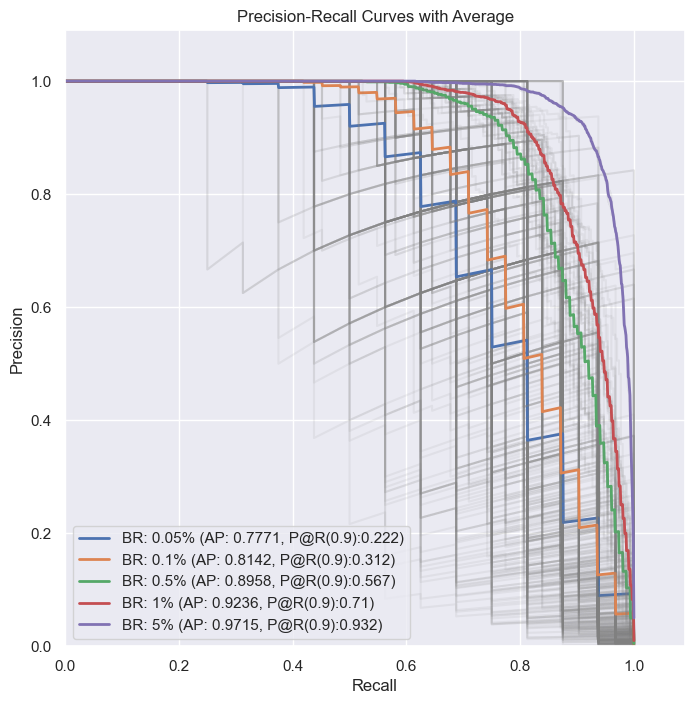

In [127]:
plot_pr_curve(b, nums, pb_dict)

In [105]:
np.mean([0.7771, 0.8142, 0.8958, 0.9236, 0.9715]), np.mean([0.222, 0.312, 0.567, 0.71, 0.932]) 

(0.87644, 0.5486)

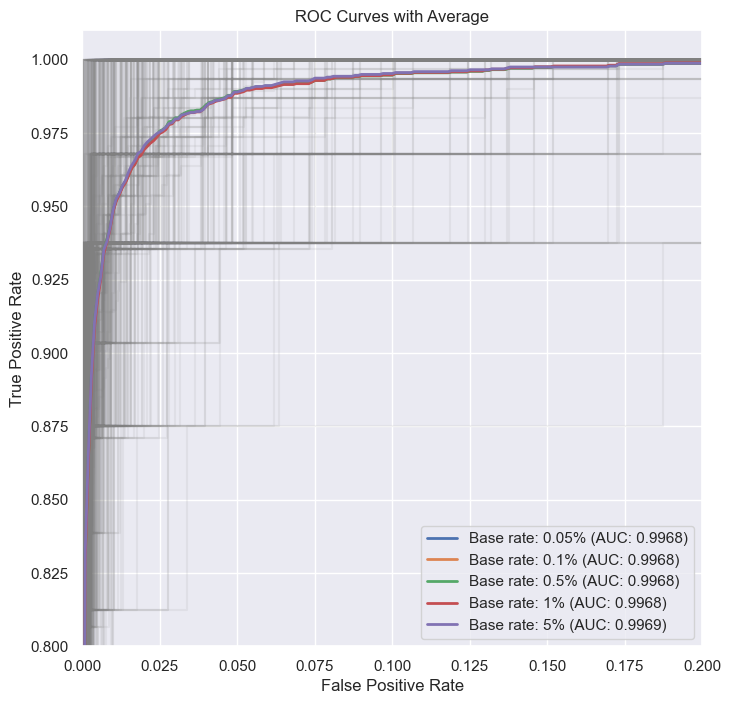

In [101]:
plot_roc_curve(b, nums, pb_dict)

In [33]:
241 + 124 + 25 + 12 + 2, 276 + 138 + 28 + 14 + 2

(404, 458)

In [43]:
nums

{'0.05': 241, '0.1': 124, '0.5': 25, '1': 12, '5': 2}